In [30]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from build_wholesale_prices import get_extremes, get_price_distribution

In [3]:
path = Path.cwd().parent / 'data' / 'base'

In [24]:
bids = []
offers = []
pns = []
dah = []

for d in tqdm(os.listdir(path)):

    try:
        bids.append(
            pd.read_csv(path / d / 'bids.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        offers.append(
            pd.read_csv(path / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        pns.append(
            pd.read_csv(path / d / 'physical_notifications.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass

    try:
        dah.append(
            pd.read_csv(path / d / 'day_ahead_prices.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass


offers = pd.concat(offers)
bids = pd.concat(bids)
pns = pd.concat(pns)
dah = pd.concat(dah)

100%|██████████| 851/851 [00:51<00:00, 16.46it/s]


In [26]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)
h = bmus.loc[bmus['carrier'] == 'hydro'].index

bidding_h = h.intersection(bids.columns)
offering_h = h.intersection(offers.columns)

In [27]:
idx = pd.IndexSlice

b = bids.loc[idx[:, 'price'], bidding_h].std().sort_values(ascending=True)

<Axes: >

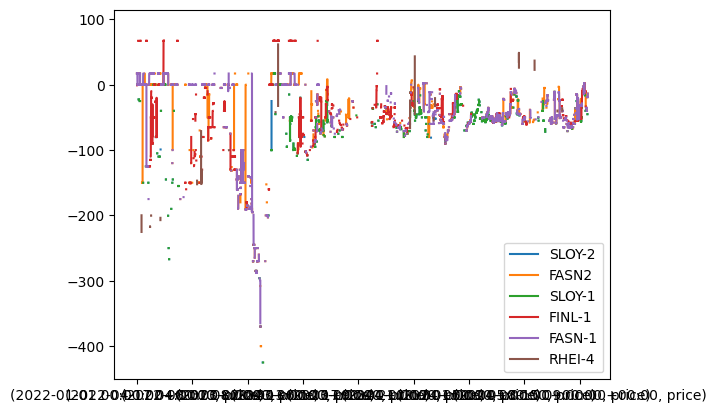

In [28]:
bids.loc[idx[:, 'price'], b.index[-6:]].plot()

<Axes: >

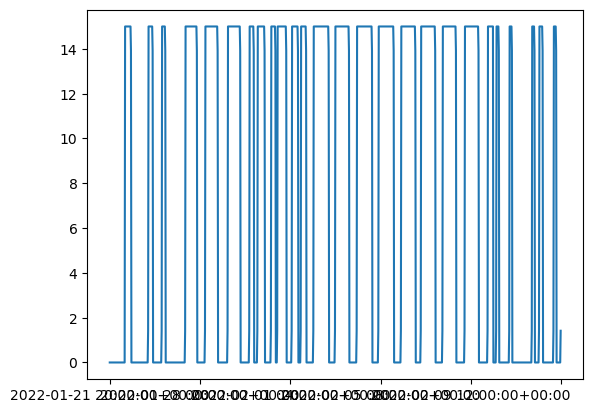

In [32]:
# pns[h].iloc[:500].plot()
pns['NANT-1'].iloc[1000:2000].plot()